# Titanic Corvus Guide - Part II - Neural Networks Solution
This notebook is continuation of the ??? notebook, where we used simple Scikit Learn models to write an ensemble solution and get to the top 15%. The question is: can we use the knowledge we already got about the Titanic Dataset and develop a new solution using neural networks? Let's see!

# 1. Once Again - The Libraries
Let-me say it again - It's a good practice to start by importing all used libraries at once.

In [1]:
# BASIC LIBRARIES
import numpy as np
import pandas as pd
import tensorflow as tf

# SKLEARN TRANSFORMATIONS AND PIPELINES
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# NON-SUPERVISED LEARNING
from sklearn.cluster import DBSCAN

# SUPERVISED LEARNING - NEURAL NETWORKS LIBS
from keras.models import Sequential
from keras.layers import Dense, Dropout, AlphaDropout

# MODEL SELECTION LIBS
import tensorflow.keras.backend as K

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from keras.optimizers import Nadam

# PLOTTING LIBS
import seaborn as sns
import matplotlib as mpl

# ACESSORY LIBRARIES
import re
import os
import dill
import time
import math
import random

from collections import Counter
from IPython.display import Image, FileLink

Using TensorFlow backend.


In [ ]:
tf.random.set_random_seed(42)
random.seed(42)
np.random.seed(42)

In [2]:
data_dir = '.'
K.clear_session()
%load_ext tensorboard.notebook

In [3]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 10994), started 3:45:26 ago. (Use '!kill 10994' to kill it.)

# 2. Taking Previous Results
What do we already have? Simple:
* 2.A The functions used in the transformations
* 2.B The transformations used in the pipelines
* 2.C The feature importance obtained during the Random Forest Algorithm (which can serve as a subside for us)

# 2.A Functions Used in the Transformations

## 2.A.1. Significant Data Transformations

Functions to separe and classify the titles - Classifying the titles is important to reduce the number of classifications after aggregating the rare occurrences.

In [4]:
def get_title(dataframe_in):
    dataframe_in['Title'] = dataframe_in['Name'].apply(lambda X: re.search('[A-Z]{1}[a-z]+\.', X).group(0))
    return dataframe_in

def classify_title(dataframe_in):
    dataframe_in.loc[:, ['Title']] = dataframe_in['Title'].apply(lambda X: X if X in ['Mr.', 'Miss.', 'Mrs.', 'Master.'] else 'Rare')
    return dataframe_in

Function to extract the family from the "Name" feature.

In [5]:
def get_family_name(dataframe_in):
    dataframe_in['FamilyName'] = dataframe_in['Name'].apply(lambda X: X.split(',')[0])
    return dataframe_in

In [6]:
def get_cabin_letter(dataframe_in):
    def first_letter_if_exists(str_in):
        if pd.isnull(str_in):
            return '?'
        return str_in[0]
    dataframe_in['Cabin'] = dataframe_in['Cabin'].apply(first_letter_if_exists)
    return dataframe_in

In [7]:
def get_cabins_per_family(dataframe_in):
    dataframe_in = get_family_name(dataframe_in)
    dict_cabins_per_family = dict()
    for current_family_name in dataframe_in.FamilyName.unique().tolist():
    
        filter_family_name = (dataframe_in['FamilyName'] == current_family_name)
        filter_known_cabin = (dataframe_in['Cabin'] != '?')
        listCabinsFromFamily = dataframe_in.loc[(filter_family_name) & (filter_known_cabin)].Cabin.unique().tolist()
    
        if len(listCabinsFromFamily) > 0:
            max_v, mode = 0, None
            for curr_cabin, v in Counter(listCabinsFromFamily).items():
                if v > max_v:
                    max_v, mode = v, curr_cabin
            dict_cabins_per_family[current_family_name] = mode
    
    return dict_cabins_per_family

Functions to relate each family to a cabin. First we define the function to be applied to each row:

In [8]:
def get_family_cabin_per_row(df_row, dict_family_in):
    dict_cabins_per_family = dict_family_in
    
    if df_row.FamilyName in dict_cabins_per_family and df_row.Cabin == '?':
        out = dict_cabins_per_family[df_row.FamilyName]
    else:
        out = df_row.Cabin
    return out

Then apply the function over all the dataframe...

In [9]:
def get_family_cabin(df, dict_family_in):
    
    df['Cabin'] = df.apply(lambda X: get_family_cabin_per_row(X, dict_family_in), axis = 1)
    df['Cabin'] = df['Cabin'].fillna('?')
    
    return df

## 2.A.2. Missing Data Transformations

We saw that all the people with a "Master" title were really young. Then, the variance of that group was small and it was possible to separe the algorithm in two partes: (1) filling the missing age of the "Masters" (which can be done easily by simply filling the NA's with the median or average value of the master people) and (2) filling the age missing values of the "Non Masters", which can be done with the same procedure.

Filling the ages with means and medians to the second case can lead us many mistakes since the variance is not small to that group. That's why we propose to use a clustering algorithm to separe the people in different groups.

In [10]:
def fill_age_from_masters(df, strategy_in = 'median'):
    is_master = (df['Title'] == 'Master.')
    imp = SimpleImputer(missing_values = np.nan, strategy = strategy_in)
    df.loc[is_master, 'Age'] = imp.fit_transform(df.loc[is_master][['Age']])
    return df

In [11]:
def fill_age_from_non_masters(df, strategy_in = 'median'):
    is_not_master = (df['Title'] != 'Master.')
    imp = SimpleImputer(missing_values = np.nan, strategy = strategy_in)
    df.loc[is_not_master, 'Age'] = imp.fit_transform(df.loc[is_not_master][['Age']])
    return df

# 2.B. Transformations Used in Pipelines

## 2.B.1. Transform Significant Data
A transformation that represents the extraction of significant variables, defined during the feature exploration step.

In [12]:
class TransformerSignificantData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        out = get_family_name(X)
        
        out = get_title(out)
        out = classify_title(out)
        
        out = get_cabin_letter(out)
        dict_cabins_per_family = get_cabins_per_family(out)
        out = get_family_cabin(out, dict_cabins_per_family)

        return out

## 2.B.2. Transformer Dummify
As the name suggests, it's the transformation responsible to the "dummification" of variables by using one-hot encoding and removind one category per feature hot-encoded (to avoid the curse of dimentionality).

In [13]:
class TransformerDummify(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        columns_to_dummify = ['Sex', 'Cabin', 'Embarked', 'Title']
        useless_columns = ['PassengerId', 'Name', 'Ticket', 'FamilyName']
        dim_redundant_cols = ['Sex_male', 'Cabin_?', 'Embarked_S', 'Title_Rare']
        
        out_dummies = pd.get_dummies(X[columns_to_dummify], prefix = columns_to_dummify)
        
        out = pd.concat([X, out_dummies], axis =1)
        out = out.drop(useless_columns + columns_to_dummify + dim_redundant_cols, axis = 1)
        
        return out

## 2.B.3. Transformer Missing Data
Transformer that inputs all the missing data. A special attention was given to the "Age" feature and the procedure of label propagation over DBSCAN clusters was used:

In [14]:
class TransformerMissingData(BaseEstimator, TransformerMixin):
    
    def __init__(self, missing_age_masters_strategy='mean', missing_age_non_masters_strategy='cluster'):
        self.missing_age_masters_strategy = missing_age_masters_strategy
        self.missing_age_non_masters_strategy = missing_age_non_masters_strategy
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):

        is_not_master = (X['Title_Master.'] == 0)
        is_master = (X['Title_Master.'] == 1)
        
        imp_non_master = SimpleImputer(missing_values = np.nan, 
                                       strategy = self.missing_age_non_masters_strategy)
        
        imp_master = SimpleImputer(missing_values = np.nan, 
                                   strategy = self.missing_age_masters_strategy)
        
        imp_fare = SimpleImputer(missing_values = np.nan,
                                 strategy = 'mean')
        
        X.loc[is_master, 'Age'] = imp_master.fit_transform(X.loc[is_master, ['Age']])
        X.loc[:, 'Fare'] = imp_fare.fit_transform(X.loc[:, ['Fare']])
        
        if self.missing_age_non_masters_strategy in ['mean', 'median']:
            X.loc[is_not_master, 'Age'] = imp_non_master.fit_transform(X.loc[is_not_master, ['Age']])
            
        elif self.missing_age_non_masters_strategy == 'cluster':
            
            X_without_age = X.drop(['Age', 'Survived'], axis = 1)
            pca_fit_vec = PCA(n_components = 3).fit_transform(X_without_age)
            
            X['ClusterLabel'] = DBSCAN(eps = 0.7, min_samples = 20).fit_predict(pca_fit_vec)
            dict_means_per_cluster = dict()
            for cluster_label in X['ClusterLabel'].tolist():
                dict_means_per_cluster[cluster_label] = X.loc[X['ClusterLabel'] == cluster_label, :]['Age'].mean()
            
            age_list = X['Age'].tolist()
            cluster_list = X['ClusterLabel'].tolist()
            for i, curr_age in enumerate(age_list):
                if np.isnan(curr_age):
                    age_list[i] = dict_means_per_cluster[cluster_label]
            X['Age'] = age_list
            X.drop('ClusterLabel', axis=1, inplace=True)
                
        return X

And after all these transformations, we just normalize the data:

In [15]:
class TransformerNormalize(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        out = X
        out.loc[:, ['Pclass']] = MinMaxScaler().fit_transform(out[['Pclass']])
        out.loc[:, ['Age', 'Fare']] = StandardScaler().fit_transform(out[['Age', 'Fare']])
        
        return out

# 2.C. Pipelines

## 2.C.1. Feature Engineering Pipeline
The pipeline where the data is preprocessed according to the transformations exposed in the previous step. The hyper-parameters of those transformations can, with this instance, be tunned:

In [16]:
feature_engineering_pipeline = Pipeline([
    ('prepare', TransformerSignificantData()),
    ('dummify', TransformerDummify()),
    ('normalize', TransformerNormalize()),
    ('missing', TransformerMissingData())
])

## 2.C.2. Train and Test Splitting Procedure

Let's take the code to split the train / validation set and the testing set as a function. Remember that the training and validating occur in the same set because we are using a Cross Validation K-Fold procedure:

In [17]:
def split_cv_test(df_all_processed):
    df_ans = df_all_processed[df_all_processed['Survived'].isnull()]
    df_ans = df_ans.loc[:, df_ans.columns != 'Survived']
    df_cv_and_test = df_all_processed[df_all_processed['Survived'].notnull()]
    df_cv_and_test_X = df_cv_and_test.drop(['Survived'], axis = 1)
    df_cv_and_test_Y = df_cv_and_test['Survived']
    df_cv_X, df_test_X, df_cv_Y, df_test_Y = train_test_split(df_cv_and_test_X,
                                                              df_cv_and_test_Y,
                                                              test_size = 0.1)
    return df_cv_X, df_cv_Y, df_test_X, df_test_Y, df_ans, df_cv_and_test_X, df_cv_and_test_Y

# 3. Starting the Game - Titanic - A NN Approach
Applying Preprocessing Pipeline
Let's read and pre-process our data just like before:

In [18]:
df_in = [pd.read_csv(data_dir + '/train.csv'), pd.read_csv(data_dir + '/test.csv')]
df_in = pd.concat(df_in, ignore_index = True, sort = False)
df_in.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [19]:
df_in_norm = feature_engineering_pipeline.transform(df_in)
print(df_in_norm.describe())

         Survived       Pclass          Age        SibSp        Parch  \
count  891.000000  1309.000000  1309.000000  1309.000000  1309.000000   
mean     0.383838     0.647441    -0.004648     0.498854     0.385027   
std      0.486592     0.418918     0.904092     1.041658     0.865560   
min      0.000000     0.000000    -2.062328     0.000000     0.000000   
25%      0.000000     0.500000    -0.547050     0.000000     0.000000   
50%      0.000000     1.000000     0.029271     0.000000     0.000000   
75%      1.000000     1.000000     0.355314     1.000000     0.000000   
max      1.000000     1.000000     3.478882     8.000000     9.000000   

               Fare   Sex_female      Cabin_A      Cabin_B      Cabin_C  ...  \
count  1.309000e+03  1309.000000  1309.000000  1309.000000  1309.000000  ...   
mean  -1.058486e-16     0.355997     0.018335     0.055768     0.075630  ...   
std    1.000000e+00     0.478997     0.134210     0.229560     0.264507  ...   
min   -6.435292e-01   

# 3.A. Defyning Neural Network Model to Apply
To create our neural network model, we will use the "Keras Library". The idea here is to test different architectures, enhancing the hyperparameters little by little. It's impossible to GridSearch over all possible neural networks that we can apply. We are going to tune the number of hidden layers and the activation function for three different models:

* An ordinary Feed Foward Neural Network
* A Neural Network using a standard DropOut function
* A Neural Network using an AlphaDropOut function

The DropOut's will employ a DropOut rate of $50\%$.

In [21]:
n_col = len(df_in_norm.columns)
def nn_layers_and_activation(n_hidden_layers, activation_func, dropout=None):
    
    in_layer_args = dict(
        units = n_col - 1,
        activation = activation_func,
        input_dim = n_col - 1,
        kernel_initializer = 'lecun_uniform'
    )
    
    out_layer_args = dict(
        units = 1,
        activation = 'sigmoid',
        input_dim = n_col - 1,
        kernel_initializer = 'lecun_uniform'
    )
    
    model_args = dict(
        loss = 'binary_crossentropy',
        optimizer = 'nadam',
        metrics = ['binary_accuracy']
    )
    
    SelectedDropout = Dropout if dropout == 'Dropout' else AlphaDropout
    out_model = Sequential()
    for i in range(0, n_hidden_layers + 1):
        out_model.add(Dense(**in_layer_args))
        if dropout is not None:
            out_model.add(SelectedDropout(rate=0.5))
        
    out_model.add(Dense(**out_layer_args))
    out_model.compile(**model_args)
    return out_model
    

test_nn = nn_layers_and_activation(1, 'relu')
print(test_nn)

Instructions for updating:
Colocations handled automatically by placer.


Notice that:
* We are defining the number of hidden layers, not the number of total layers ($N_{Total Layers} = N_{Hidden Layers} + 2$)
* Since the output can get values equal to zero or one, we are defining the output function as a simple sigmoid (generally, the output function is defined by the type of problem - regression or classification - and by the number of outputs - for problems with multiple classes, we use the softmax function and for binary classification, it's common to employ the logistic function as we have done here).
Let's try to tune our hyperparameters, testing different numbers of $N_{Hidden Layers}$ and creating a pipeline to realize our GridSearch. But, before, let's separe out training and test sets:

In [22]:
df_cv_X, df_cv_Y, df_test_X, df_test_Y, df_ans, df_cv_and_test_X, df_cv_and_test_Y = split_cv_test(df_in_norm)
print(df_cv_X.head())

     Pclass       Age  SibSp  Parch      Fare  Sex_female  Cabin_A  Cabin_B  \
740     0.0  0.029271      0      0 -0.063694           0        0        0   
332     0.0  0.563552      0      1  2.322567           0        0        0   
22      1.0 -1.032939      0      0 -0.488342           1        0        0   
866     0.5 -0.199987      1      0 -0.375678           1        0        0   
748     0.0 -0.755288      1      0  0.382778           0        0        0   

     Cabin_C  Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  Embarked_C  \
740        0        1        0        0        0        0           0   
332        1        0        0        0        0        0           0   
22         0        0        0        0        0        0           0   
866        0        0        0        0        0        0           1   
748        0        1        0        0        0        0           0   

     Embarked_Q  Title_Master.  Title_Miss.  Title_Mr.  Title_Mrs.  
740           0  

First, let's try to find the optimal activation function using common values to all the others hyperparameters.

In [24]:
wrapped_tune_layers_and_activation = KerasClassifier(build_fn=nn_layers_and_activation, 
                                                     batch_size=64, 
                                                     verbose=0)

nn_pipeline = Pipeline([
    ('tune_layers_and_activation', wrapped_tune_layers_and_activation)
])

def gen_scheduler(eta=0.1, epoch0=100.0):
    def exp_decay_fn(epoch, lr):
        return lr * eta ** (epoch / epoch0)
    return LearningRateScheduler(exp_decay_fn)

tensorboard_cb = TensorBoard(run_logdir)
dict_params_standard = dict(
    tune_layers_and_activation__n_hidden_layers = [1, 4, 3, 5, 10],
    tune_layers_and_activation__epochs = [100],
    tune_layers_and_activation__activation_func = ['sigmoid', 'relu', 'tanh', 'selu'],
    tune_layers_and_activation__dropout = [None],
    tune_layers_and_activation__callbacks = [[gen_scheduler(epoch0=X), 
                                              EarlyStopping(patience=10, restore_best_weights=False)]\
                                              for X in [900, 1000, 1100, 1200]]
)
dict_params_dropout = dict(
    tune_layers_and_activation__n_hidden_layers = [1, 4, 3, 5, 10],
    tune_layers_and_activation__epochs = [100],
    tune_layers_and_activation__activation_func = ['sigmoid', 'relu', 'tanh', 'selu'],
    tune_layers_and_activation__dropout = ['Dropout'],
    tune_layers_and_activation__callbacks = [[gen_scheduler(epoch0=X), 
                                              EarlyStopping(patience=10, restore_best_weights=False)]\
                                              for X in [900, 1000, 1100, 1200]]
)
dict_params_alphadropout = dict(
    tune_layers_and_activation__n_hidden_layers = [1, 4, 3, 5, 10],
    tune_layers_and_activation__epochs = [100],
    tune_layers_and_activation__activation_func = ['sigmoid', 'relu', 'tanh', 'selu'],
    tune_layers_and_activation__dropout = ['AlphaDropout'],
    tune_layers_and_activation__callbacks = [[gen_scheduler(epoch0=X), 
                                              EarlyStopping(patience=10, restore_best_weights=False)]\
                                              for X in [900, 1000, 1100, 1200]]
)

In [26]:
cv_pipeline_standard = GridSearchCV(estimator=nn_pipeline, param_grid=dict_params_standard, 
                                    scoring='accuracy', cv=3, verbose=10, n_jobs=-1)

cv_pipeline_dropout = GridSearchCV(estimator=nn_pipeline, param_grid=dict_params_dropout, 
                                   scoring='accuracy', cv=3, verbose=10, n_jobs=-1)

cv_pipeline_alphadropout = GridSearchCV(estimator=nn_pipeline, param_grid=dict_params_alphadropout, 
                                        scoring='accuracy', cv=3, verbose=10, n_jobs=-1)

print('Fitting model without Dropout')
cv_pipeline_standard.fit(df_cv_X, df_cv_Y)
print('Fitting model with Dropout')
cv_pipeline_dropout.fit(df_cv_X, df_cv_Y)
print('Fitting model with AlphaDropout')
cv_pipeline_alphadropout.fit(df_cv_X, df_cv_Y)

Fitting model without Dropout
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3

Instructions for updating:
Use tf.cast instead.


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  5.4min finished
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:842: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,binary_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Fitting model with Dropout
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  9

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 14.0min finished


Fitting model with AlphaDropout
Fitting 3 folds for each of 80 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 16.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 18

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tune_layers_and_activation',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f83fcebd710>)],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'tune_layers_and_activation__activation_func': ['sigmoid',
                                                                         'relu',
                                                                         'tanh',
                                                                         'selu'],
                         'tune_layers_and_activation__callba...
                         'tune_layers_and_activation__dropout': ['AlphaDropout'],
                         'tune_layers_and_activation__epochs': [100],
                         'tune_layers_and_activation__n_hidden_layers': [1, 4,
            

After tunning the parameters, we have just saved all variables from our session. Now, it's time to check out the optimal neural network we just got.

In [215]:
for i, cv_pipeline in enumerate([cv_pipeline_standard, cv_pipeline_dropout, cv_pipeline_alphadropout]):
    list_models = ['No Dropout', 'Std Dropout', 'AlphaDropout']
    
    print('----')
    print(list_models[i] + '- Results:')
    print('----')
    print('Paramaters:')
    dict_params = cv_pipeline.best_estimator_.named_steps['tune_layers_and_activation'].get_params()
    print('Act. Fn: ' + dict_params['activation_func'])
    print('Model: ' + (dict_params['dropout'] if dict_params['dropout'] is not None else 'No Dropout'))
    print('N. Hidden Layers: ' + str(dict_params['n_hidden_layers']))
    
    print('Optimal Exp. Decay:')
    dict_params = cv_pipeline.best_estimator_.named_steps['tune_layers_and_activation'].get_params()
    opt_scheduler = dict_params['callbacks'][0]
    opt_scheduler_fn = opt_scheduler.__dict__['schedule']
    opt_epoch0 = 1 / (math.log10(opt_scheduler_fn(0, 1)) - math.log10(opt_scheduler_fn(1, 1)))
    print(f'Epoch0 = %f' % opt_epoch0)
    
    print('Best Score:')
    print('{0:.0%}'.format(cv_pipeline.best_score_))
    print('\n')

----
No Dropout- Results:
----
Paramaters:
Act. Fn: tanh
Model: No Dropout
N. Hidden Layers: 3
Optimal Exp. Decay:
Epoch0 = 900.000000
Best Score:
83%


----
Std Dropout- Results:
----
Paramaters:
Act. Fn: relu
Model: Dropout
N. Hidden Layers: 1
Optimal Exp. Decay:
Epoch0 = 1100.000000
Best Score:
83%


----
AlphaDropout- Results:
----
Paramaters:
Act. Fn: selu
Model: AlphaDropout
N. Hidden Layers: 1
Optimal Exp. Decay:
Epoch0 = 1000.000000
Best Score:
81%




Seems that the Standard Dropout model is the best one: it offers similar results of the Neural Network without Dropping Out but with a difference: it uses a smaller number of Hidden Layers and has a bigger exponencial decay. So, the Dropping Out Neural Network is going to be chosen since it's simpler.

Let's compare the result along each fold for each one of the models in a BoxPlot:

In [160]:
cv_pipeline_standard.cv_results_['split0_test_score']

def get_cv_compared_results(cv_obj_list, cv_obj_names):
    
    obj_cv0 = cv_obj_list[0]
    n_splits = obj_cv0.n_splits_
    param_list = obj_cv0.param_grid.keys()
    dict_df_cv = dict()
    
    for param in param_list:
        dict_df_cv[param.split('__')[1]] = []
        dict_df_cv['OPT__' + param.split('__')[1]] = []
        
    dict_df_cv['Score'] = []
    dict_df_cv['Split'] = []
    dict_df_cv['Model'] = []
    
    df_compared_results = pd.DataFrame(dict_df_cv)
    for idx, obj_cv in enumerate(cv_obj_list):
        
        obj_name = cv_obj_names[idx]
        opt_dict = obj_cv.best_estimator_.named_steps['tune_layers_and_activation'].get_params()
        
        for i, param in enumerate(obj_cv.cv_results_['params']):
            for j in range(0, n_splits):
                
                dict_new_row = dict()
                    
                dict_new_row['Score'] = [obj_cv.cv_results_['split' + str(j) + '_test_score'][i]]
                dict_new_row['Split'] = [j]
                dict_new_row['Model'] = [obj_name]
                
                for param_id, param_val in param.items():
                    
                    param_name = param_id.split('__')[1]
                    
                    dict_new_row[param_name] = [param_val]
                    dict_new_row['OPT__' + param_name] = [opt_dict[param_name]]
                    
            df_compared_results = pd.concat([df_compared_results, pd.DataFrame(dict_new_row)], axis=0, ignore_index=True)

    return df_compared_results
        
    
cv_obj_list = [cv_pipeline_standard, cv_pipeline_dropout, cv_pipeline_alphadropout]
cv_names_list = ['No Dropout', 'Simple Dropout', 'AlphaDropout']

df_compared_results = get_cv_compared_results(cv_obj_list, cv_names_list)
df_compared_results.head()

/home/x/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,Model,OPT__activation_func,OPT__callbacks,OPT__dropout,OPT__epochs,OPT__n_hidden_layers,Score,Split,activation_func,callbacks,dropout,epochs,n_hidden_layers
0,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.842697,2.0,sigmoid,[<keras.callbacks.LearningRateScheduler object...,None,100.0,1.0
1,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.838951,2.0,sigmoid,[<keras.callbacks.LearningRateScheduler object...,None,100.0,4.0
2,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.842697,2.0,sigmoid,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0
3,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.846442,2.0,sigmoid,[<keras.callbacks.LearningRateScheduler object...,None,100.0,5.0
4,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.647940,2.0,sigmoid,[<keras.callbacks.LearningRateScheduler object...,None,100.0,10.0


In [161]:
act_fn_used = df_compared_results['activation_func'] == df_compared_results['OPT__activation_func']
df_compared_results_fn_filtered = df_compared_results.loc[act_fn_used, :]
df_compared_results_fn_filtered.head()

,Model,OPT__activation_func,OPT__callbacks,OPT__dropout,OPT__epochs,OPT__n_hidden_layers,Score,Split,activation_func,callbacks,dropout,epochs,n_hidden_layers
40,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.835206,2.0,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,1.0
41,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.827715,2.0,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,4.0
42,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.850187,2.0,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0
43,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.838951,2.0,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,5.0
44,No Dropout,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,3.0,0.812734,2.0,tanh,[<keras.callbacks.LearningRateScheduler object...,None,100.0,10.0


In [155]:
df_compared_results_fn_filtered.dtypes

Model                    object
OPT__activation_func     object
OPT__callbacks           object
OPT__dropout             object
OPT__epochs             float64
OPT__n_hidden_layers    float64
Score                   float64
Split                   float64
activation_func          object
callbacks                object
dropout                  object
epochs                  float64
n_hidden_layers         float64
dtype: object

/home/x/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


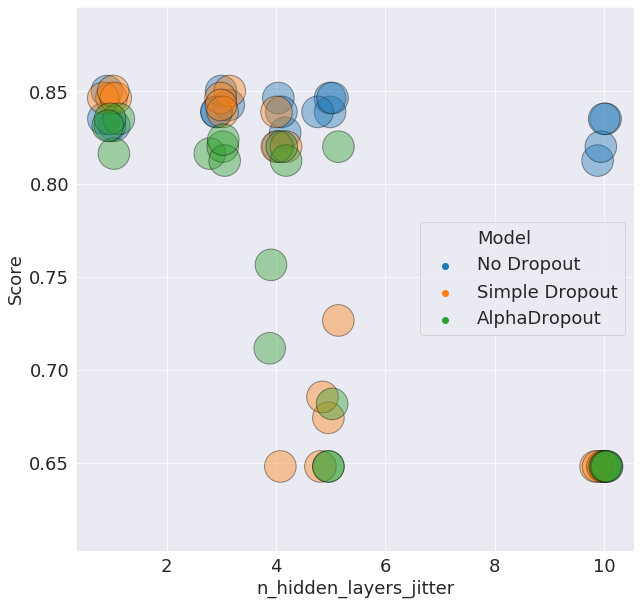

In [174]:
mpl.rcParams['figure.figsize'] = [10, 10]
sns.set_style("darkgrid")
df_compared_results_fn_filtered['n_hidden_layers_jitter'] = df_compared_results_fn_filtered['n_hidden_layers'].apply(lambda X: X + 0.1 * np.random.normal())
sns.scatterplot(data=df_compared_results_fn_filtered, x='n_hidden_layers_jitter', y='Score', hue='Model',  linewidth=1, s=1000, alpha=0.4, edgecolor='k')

# 3.B. Prepare a TensorBoard and inspect the Neural Networks in a Separated Validation Set
The Cross-Validation procedure executes the hyper-parameter tunning over different splits of the same set. For that reason, to inspect the generalization power of our models we are going to look out of that set and inspect the Learning Curves of the $3$ optimal models (without Dropping Out, with DropOut and with AlphaDropout) using the TensorBoard tool. The model fitting will be executed over all the Cross Validation data to inspect the results when we increase the number of samples for each Neural Network.

In [227]:
for i, cv_obj in enumerate([cv_pipeline_standard, cv_pipeline_dropout, cv_pipeline_alphadropout]):
    tensor_board_callback = [TensorBoard('./logs/Model-' + str(i + 1), histogram_freq=0, write_graph=False)]
    cbcks_list = cv_obj.best_estimator_.steps[0][1].__dict__['sk_params']['callbacks'] + tensor_board_callback
    cv_obj.best_estimator_.fit(df_cv_X, df_cv_Y, 
                               tune_layers_and_activation__callbacks=cbcks_list,
                               tune_layers_and_activation__validation_data=(df_test_X, df_test_Y))
    
    cv_obj.best_estimator_.fit(df_cv_and_test_X, df_cv_and_test_Y, 
                               tune_layers_and_activation__callbacks=cv_obj.best_estimator_.steps[0][1].__dict__['sk_params']['callbacks'])

    df_submission = pd.read_csv(data_dir + '/test.csv')
    df_submission['Survived'] = cv_obj.best_estimator_.predict(df_ans)
    df_submission['Survived'] = df_submission['Survived'].apply(int)
    df_submission = df_submission.loc[:, ['PassengerId', 'Survived']]
    df_submission.to_csv('Model-' + str(i + 1) + '-submission.csv', index=False)